In [1]:
from matplotlib import pylab 
params = {'xtick.labelsize': 18, 
'ytick.labelsize': 18, 
'axes.titlesize' : 22, 
'axes.labelsize' : 20, 
'legend.fontsize': 18, 
'legend.title_fontsize': 22, 
'figure.titlesize': 24 } 
pylab.rcParams.update(params)
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from pprint import pprint
from prepare import prepare_data
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, RegressorMixin


In [2]:
df = pd.read_csv("data_HW3.csv")
ASSAF_ID = 207376807
DANIEL_ID = 209088723
randomness = ASSAF_ID % 100 + DANIEL_ID % 100
train_set, test_set = train_test_split(
    df, random_state=randomness, test_size=0.2
)
prepared_train_set = prepare_data(df, train_set)
prepared_test_set = prepare_data(df, test_set)

['age', 'weight', 'num_of_siblings', 'happiness_score', 'household_income', 'conversations_per_day', 'sugar_levels', 'sport_activity', 'pcr_date', 'PCR_01', 'PCR_02', 'PCR_03', 'PCR_04', 'PCR_05', 'PCR_06', 'PCR_07', 'PCR_08', 'PCR_09', 'PCR_10', 'contamination_level', 'sore_throat', 'fever', 'shortness_of_breath', 'cough', 'smell_loss', 'current_location_x', 'current_location_y', 'is_special_blood', 'is_male']
<> label age is not normally distribured, p-value = 4.265696823802705e-14, stat = 0.9677310633735379
<> label weight is not normally distribured, p-value = 2.074816823085137e-06, stat = 0.9898245835330154
<> label num_of_siblings is not normally distribured, p-value = 5.229080805005748e-24, stat = 0.9087082195088065
<> label happiness_score is not normally distribured, p-value = 5.318039128589055e-23, stat = 0.9168547489519551
<> label household_income is not normally distribured, p-value = 3.1117626824038317e-25, stat = 0.8979978503469536
<> label conversations_per_day is not n

/home/dgershko/Documents/Technion/Intro_to_ml/iml_hw3/prepare.py:47: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  stat, p = shapiro(normalized_data[[label]])
/home/dgershko/Documents/Technion/Intro_to_ml/iml_hw3/prepare.py:47: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  stat, p = shapiro(normalized_data[[label]])


<++> label PCR_04 is normally distribured!, p-value = 0.7675820279460162, stat = 0.9959726719574253
<> label PCR_05 is not normally distribured, p-value = 4.936156638056901e-10, stat = 0.923749698429882
<> label PCR_06 is not normally distribured, p-value = 1.6802726165255797e-06, stat = 0.9593590096868508
<++> label PCR_07 is normally distribured!, p-value = 0.12279477144536743, stat = 0.9909177764521588
<> label PCR_08 is not normally distribured, p-value = 1.6545199663859948e-10, stat = 0.917895589774971
<++> label PCR_09 is normally distribured!, p-value = 0.4705730756817471, stat = 0.9943084256532435
<> label PCR_10 is not normally distribured, p-value = 0.004357061583451269, stat = 0.9829751124461282
<> label contamination_level is not normally distribured, p-value = 1.8337608793441532e-23, stat = 0.6093490647191279
<> label sore_throat is not normally distribured, p-value = 1.623473586303665e-23, stat = 0.6073022081915356
<> label fever is not normally distribured, p-value = 8.2

# Preliminary: Updated Data Loading

# Section 1

## Task (pre-Q4)

In [13]:
class LinearRegressor(BaseEstimator, RegressorMixin):
    """
    Custom linear regression model
    """
    def __init__(self, lr: float = 1e-5, delta: float = 1.0):
        """
        Initialize an instance of this class.
        ** Do not edit this method **

        :param lr: the SGD learning rate (step size)
        """
        self.lr = lr
        self.batch_size = 32
        self.w = None
        self.b = 0.0
        self.delta = delta

    # Initialize a random weight vector
    def init_solution(self, n_features: int):
        """
        Randomize an initial solution (weight vector)
        ** Do not edit this method **

        :param n_features:
        """
        self.w = np.zeros(n_features)
        self.b = 0.0

    def loss(self, w, b: float, X, y):
        """
        Compute the MSE objective loss.

        :param w: weight vector for linear regression; array of shape (n_features,)
        :param b: bias scalar for linear regression
        :param X: samples for loss computation; array of shape (n_samples, n_features)
        :param y: targets for loss computation; array of shape (n_samples,)
        :return: the linear regression objective loss (float scalar)
        """
        intermediate = np.dot(X, w) + b - y
        is_within_delta = np.abs(intermediate) <= self.delta
        loss_inside = lambda x: 0.5 * (x ** 2)
        loss_outside = lambda x: self.delta * (np.abs(x) - 0.5 * self.delta)    

        return np.sum(np.where(is_within_delta, loss_inside(intermediate), loss_outside(intermediate))) / X.shape[0]

    def gradient(self, w, b: float, X, y):
        """
        Compute the (analytical) linear regression objective gradient.

        :param w: weight vector for linear regression; array of shape (n_features,)
        :param b: bias scalar for linear regression
        :param X: samples for loss computation; array of shape (n_samples, n_features)
        :param y: targets for loss computation; array of shape (n_samples,)
        :return: a tuple with (the gradient of the weights, the gradient of the bias)
        """
        intermediate = np.dot(X, w) + b - y
        is_within_delta = np.abs(intermediate) <= self.delta
        g_w = np.sum(np.where(is_within_delta, X.T * intermediate, self.delta * X.T * np.sign(intermediate)), axis=1) / X.shape[0]
        g_b = np.sum(np.where(is_within_delta, intermediate, self.delta * np.sign(intermediate))) / X.shape[0]
        return g_w, g_b

    def fit_with_logs(self, X, y, max_iter: int = 1000, keep_losses: bool = True,
                      X_val  =None, y_val = None):
        """
        Fit the model according to the given training data.

        :param X: training samples; array of shape (n_samples, n_features)
        :param y: training targets; array of shape (n_samples,)
        :param max_iter: number of SGD iterations
        :param keep_losses: should compute the train & val losses during training?
        :param X_val: validation samples to compute the loss for (for logs only)
        :param y_val: validation labels to compute the loss for (for logs only)
        :return: training and validation losses during training
        """
        # Initialize learned parameters
        self.init_solution(X.shape[1])

        train_losses = []
        val_losses = []

        if keep_losses:
            train_losses.append(self.loss(self.w, self.b, X, y))
            val_losses.append(self.loss(self.w, self.b, X_val, y_val))

        # Iterate over batches (SGD)
        for itr in range(0, max_iter):
            start_idx = (itr * self.batch_size) % X.shape[0]
            end_idx = min(X.shape[0], start_idx + self.batch_size)
            batch_X = X[start_idx: end_idx]
            batch_y = y[start_idx: end_idx]

            # TCompute the gradient for the current *batch*
            g_w, g_b = self.gradient(self.w, self.b, batch_X, batch_y)

            # Perform a gradient step
            # update the learned parameters correctly
            self.w -= self.lr * g_w
            self.b -= self.lr * g_b
            # print(f"iteration {itr} b: {self.b}, w: {self.w} loss: {self.loss(self.w, self.b, X, y)}")

            if keep_losses:
                train_losses.append(self.loss(self.w, self.b,  X, y))
                val_losses.append(self.loss(self.w, self.b,  X_val, y_val))

        return train_losses, val_losses

    def fit(self, X, y, max_iter: int = 1000):
        """
        Fit the model according to the given training data.
        ** Do not edit this method **

        :param X: training samples; array of shape (n_samples, n_features)
        :param y: training targets; array of shape (n_samples,)
        :param max_iter: number of SGD iterations
        """
        self.fit_with_logs(X, y, max_iter=max_iter, keep_losses=False)

        return self

    def predict(self, X):
        """
        Regress labels on samples in X.

        :param X: samples for prediction; array of shape (n_samples, n_features)
        :return: Predicted continuous labels for samples in X; array of shape (n_samples,)
        """

        # TODO: Compute
        y_pred = np.dot(X, self.w) + self.bNone

        return y_pred

In [11]:
def numerical_subgradient(w, b, X, y, delta=1e-4):
    w_ = w.copy()
    g_w = np.zeros_like(w_)
    orig_objective = LinearRegressor(delta=0.1).loss(w_, b, X, y)
    for i in range(g_w.shape[0]):
        w_[i] += delta
        perturbed_objective = LinearRegressor(delta=0.1).loss(w_, b, X, y)
        w_[i] -= delta
        g_w[i] = (perturbed_objective - orig_objective) / delta

    g_b = (LinearRegressor(delta=0.1).loss(w_, b + delta, X, y) - orig_objective) / delta
    return g_w, g_b


def compare_gradients(X, y, deltas, C=1, REPEATS=10, figsize=(10, 6)):
    residual_means_w = []
    residual_means_b = []

    for delta in deltas:
        residuals_w = []
        residuals_b = []

        for _ in range(REPEATS):
            # Randomize vectors in which the gradient is computed
            w = np.random.randn(X.shape[1])
            b = np.random.randn(1)

            # Compute the two types of gradients
            analytic_grad_w, analytic_grad_b = LinearRegressor(delta=0.1).gradient(w, b, X, y)

            numeric_grad_w, numeric_grad_b = numerical_subgradient(w, b, X, y, delta=delta)

            # print(f"F_W: {numeric_grad_w}, A_W: {analytic_grad_w}")
            residual_w = np.linalg.norm(numeric_grad_w - analytic_grad_w)
            residuals_w.append(residual_w)
            residual_b = np.linalg.norm(numeric_grad_b - analytic_grad_b)
            residuals_b.append(residual_b)

        residual_means_w.append(np.mean(residuals_w))
        residual_means_b.append(np.mean(residuals_b))

    fig, axs = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(16, 8))
    plt.suptitle('Residuals of analytical and numerical gradients',
                 fontsize=22, fontweight="bold")
    axs[0].set_title(r'Residuals of $\nabla_{w}L\left(w,b\right)$')
    axs[1].set_title(r'Residuals of $\frac{\partial}{\partial{b}}L\left(w,b\right)$')
    axs[0].plot(deltas, residual_means_w, linewidth=3)
    axs[1].plot(deltas, residual_means_b, linewidth=3)
    axs[0].set_yscale('log')
    axs[0].set_xscale('log')
    axs[1].set_yscale('log')
    axs[1].set_xscale('log')
    axs[0].set_xlabel(r'$\delta_w$', fontsize=18)
    axs[1].set_xlabel(r'$\delta_b$', fontsize=18)
    axs[0].set_ylabel(r'$\left\Vert \nabla_{w}L\left(w,b\right) - u_{\delta_w} \left(w,b\right)\right\Vert$',
                      fontsize=18)
    axs[1].set_ylabel(
        r'$\left\Vert \frac{\partial}{\partial{b}}L\left(w,b\right) - u_{\delta_b} \left(w,b\right)\right\Vert$',
        fontsize=18)

    axs[0].grid(alpha=0.5)
    axs[1].grid(alpha=0.5)
    plt.show()


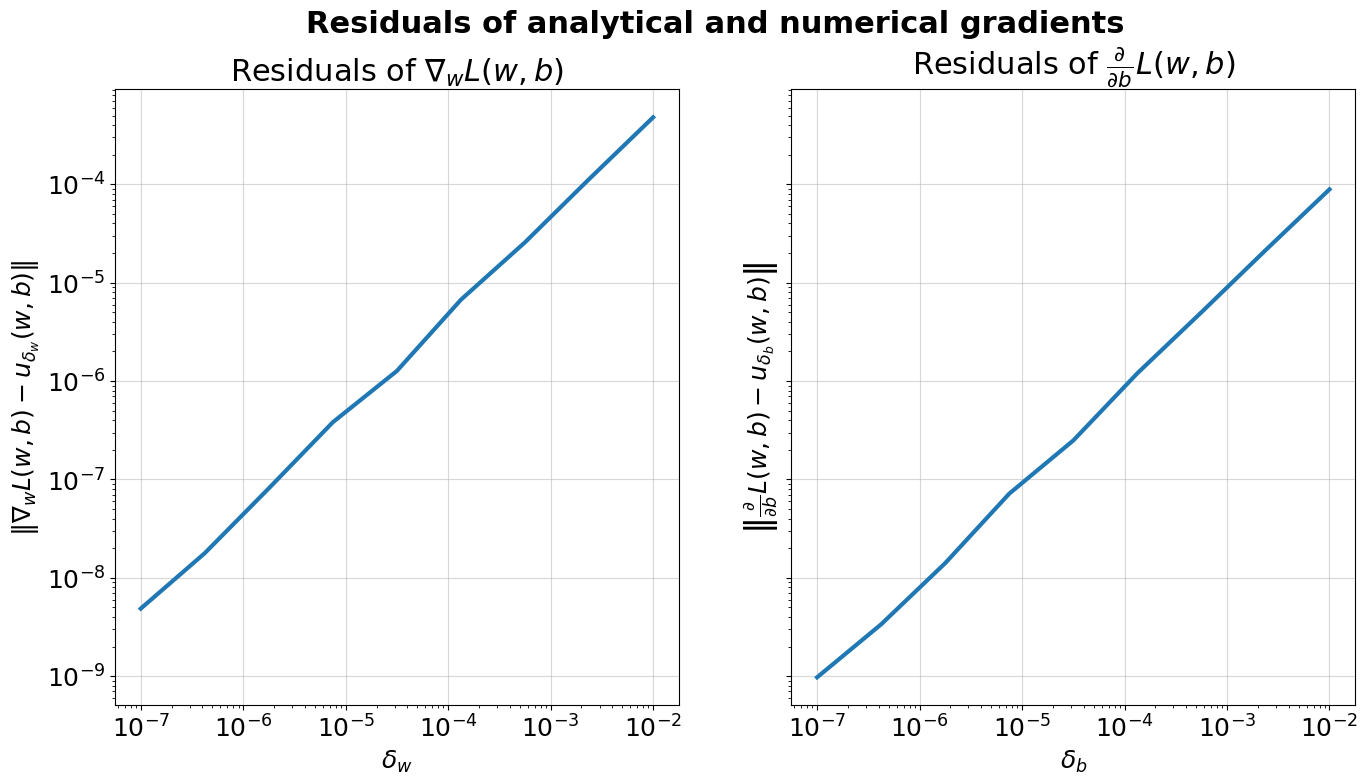

In [16]:
partial_train, partial_test = train_test_split(
    prepared_train_set, random_state=randomness, test_size=0.2
)
partial_train_X = partial_train.drop("contamination_level", axis=1).values
partial_train_y = partial_train["contamination_level"].values
compare_gradients(partial_train_X, partial_train_y, deltas=np.logspace(-7, -2, 9))

## Test LR

In [25]:
def test_lr(X_train, y_train, X_val, y_val, title: str, max_iter=1500, delta=1.0):
    lr_list = np.logspace(-9, -1, 9)

    fig, axs = plt.subplots(3, 3, sharey=True, figsize=(20, 12))
    plt.suptitle(title, fontsize=32)
    plt.tight_layout()
    fig.subplots_adjust(hspace=0.5, top=0.9)

    axs = np.ravel(axs)
    for i, lr in enumerate(lr_list):
        cur_linear_reggressor = LinearRegressor(delta=delta, lr=lr)
        train_losses, val_losses = cur_linear_reggressor.fit_with_logs(
            X_train,
            y_train,
            keep_losses=True,
            X_val=X_val,
            y_val=y_val,
            max_iter=max_iter,
        )
        print(
            "lr size = "
            + str(lr)
            + ", Best train loss = "
            + str(min(train_losses))
            + ", Best validation loss = "
            + str(min(val_losses))
        )

        iterations = np.arange(max_iter + 1)
        axs[i].semilogy(iterations, train_losses, label="Train")
        axs[i].semilogy(iterations, val_losses, label="Validation")
        axs[i].grid(alpha=0.5)
        axs[i].legend()
        axs[i].set_title("lr = " + str(lr))
        axs[i].set_xlabel("iteration")
        axs[i].set_ylabel("HOOB loss")

## Pre Q5

1.7569282886969622
lr size = 1e-09, Best train loss = 0.3488723922262812, Best validation loss = 0.3602281959203198
lr size = 1e-08, Best train loss = 0.3488566941842404, Best validation loss = 0.3602114179844118
lr size = 1e-07, Best train loss = 0.34869973374520624, Best validation loss = 0.360043659532457
lr size = 1e-06, Best train loss = 0.3471321250981467, Best validation loss = 0.3583681834621922
lr size = 1e-05, Best train loss = 0.33165787888404735, Best validation loss = 0.34182679421282036
lr size = 0.0001, Best train loss = 0.20021054360932639, Best validation loss = 0.2015330738467402
lr size = 0.001, Best train loss = 0.06966687671430058, Best validation loss = 0.06883481576424173
lr size = 0.01, Best train loss = 0.05523223000544355, Best validation loss = 0.0477429669338476
lr size = 0.1, Best train loss = 0.05406952497687941, Best validation loss = 0.043513579124701884


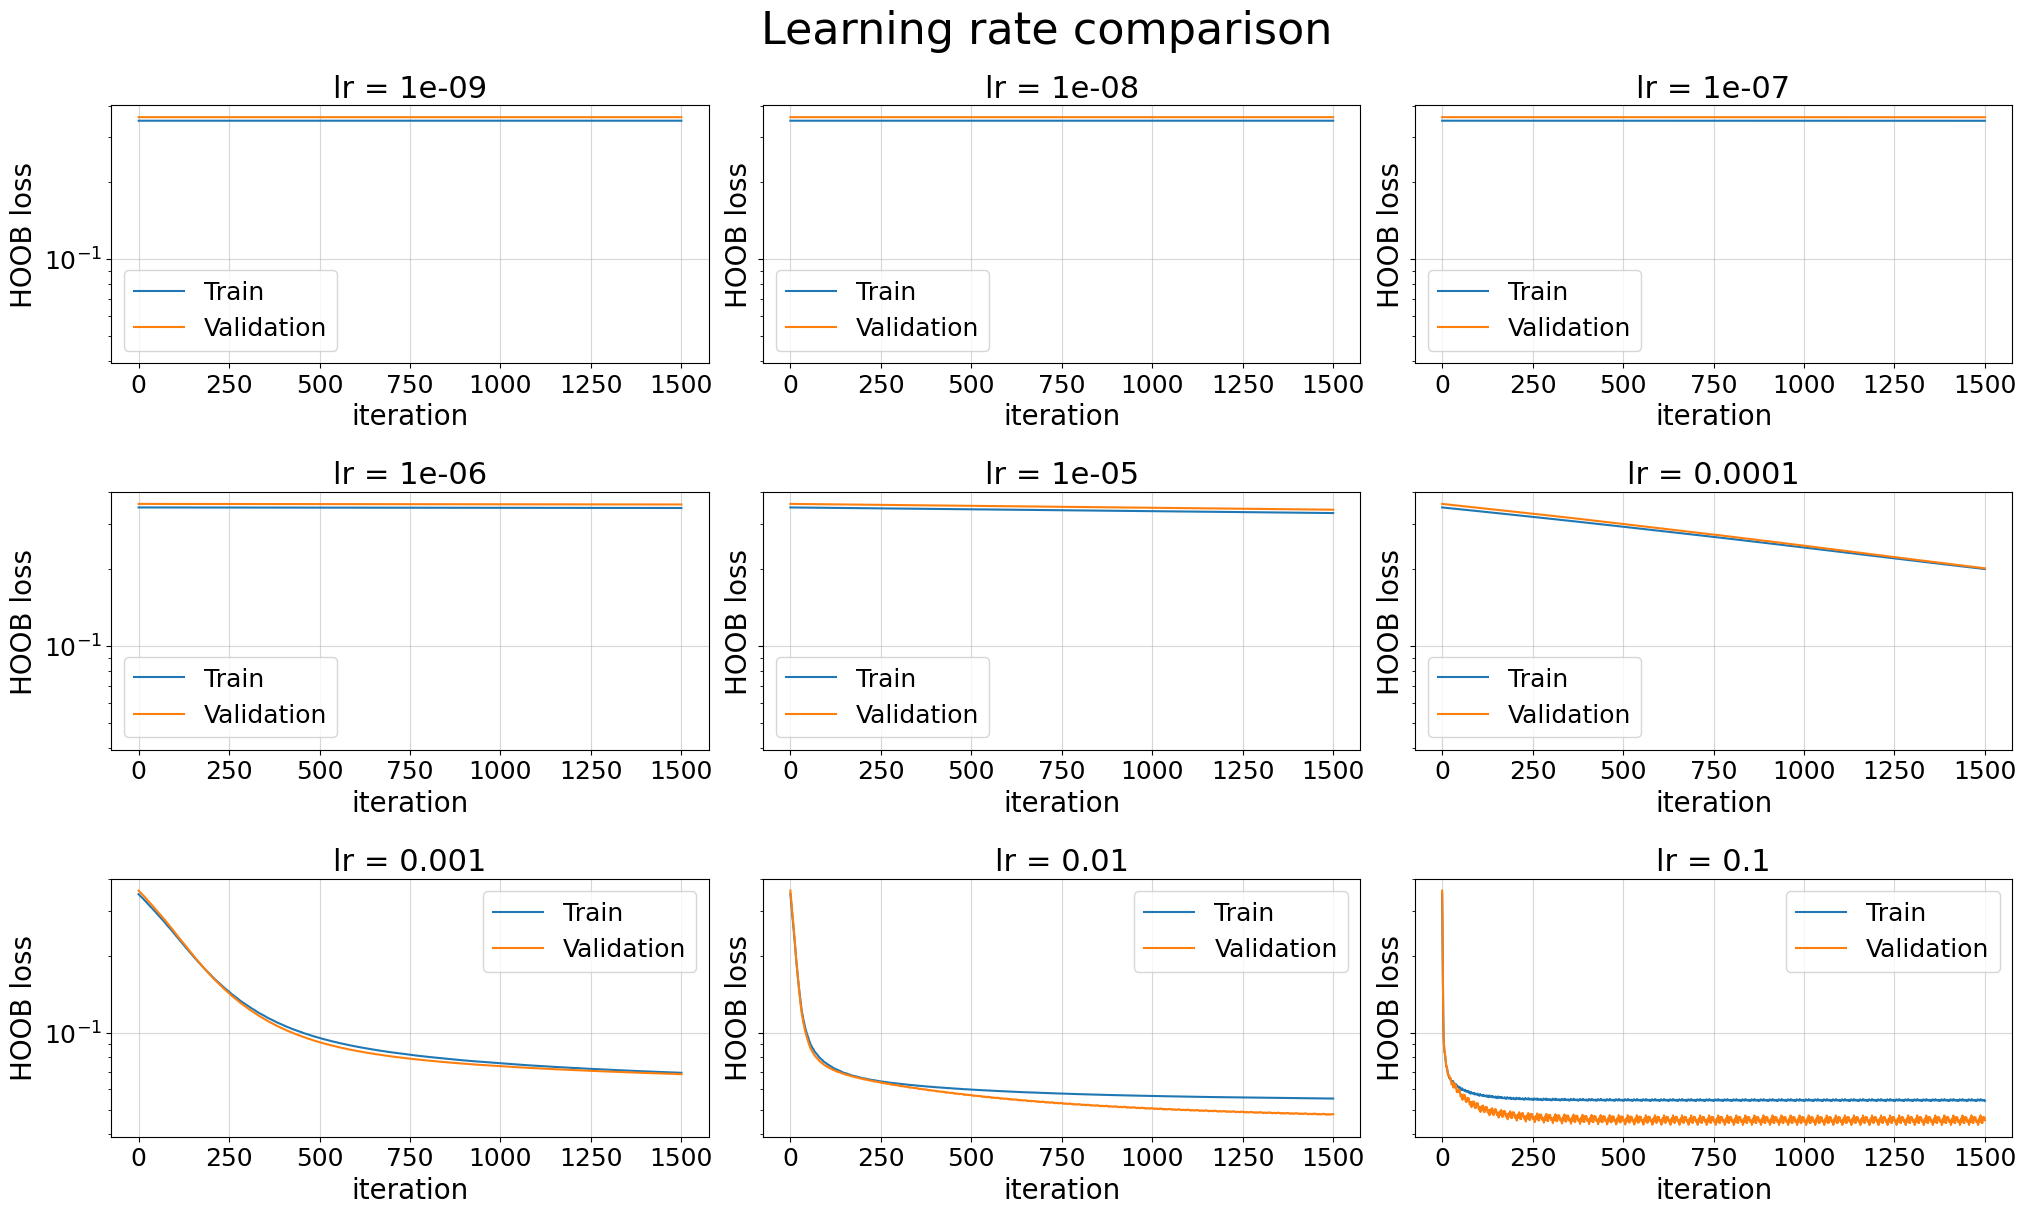

In [34]:
delta = 2 * np.std(partial_train_X)
print(delta)
test_lr(
    partial_train_X,
    partial_train_y,
    partial_test.drop("contamination_level", axis=1).values,
    partial_test["contamination_level"].values,
    "Learning rate comparison",
    delta=delta
)

## Q125

# Section 2

## Q234

## Q235

# Section 3

## Q345

## Q346

## Q347

# IML Major HW 3 - Linear Regression
| Name | ID |
|------|----|
| Daniel Gershkovich   | 209088723  |
| Assaf Alon   | 207376807  |

In [ ]:
df = pd.read_csv("data_HW3.csv")
ASSAF_ID = 207376807
DANIEL_ID = 209088723
randomness = ASSAF_ID % 100 + DANIEL_ID % 100
train_set, test_set = train_test_split(
    df, random_state=randomness, test_size=0.2
)
prepared_train_set = prepare_data(train_set, train_set)
prepared_test_set = prepare_data(train_set, test_set)